In [1]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp, ndtr
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings
import seaborn as sns

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from utils import ESS_univariate

In [2]:
seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [484]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pd_target=0.4,
    dm_target=0.01,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234,
    resampling_scheme='multinomial',
    prop_hug=0.5,
    projection_method='qr',
    metropolised=False,
    δadaptation_method='ap',
    prop_esjd=0.95,
    adaptiveB=False,
    Bmin=5,
    Bmax=100,
    proxy_ap_metric='dm',
    adaptiveN=False,
    NBbudget=None):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

In [4]:
N      = 500
B      = 30
δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1

In [8]:
θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
ystar     = data_generator(θ0, m, seed=seed)  # Observed data
q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
resetwarnings()
manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)

def generate_initial_points(ε=200, δ=0.4, N=N, mult=100):
    # Generate target distribution
    logηε = manifold.generate_logηε(ε=200)
    # Find initial point
    x0 = manifold.sample(advanced=True, fromtheta=True)
    # Sample starting from x0
    samples, acceptances = RWM(x0, s=δ, N=N*mult, logpi=logηε)
    print("AP: {:.3f}".format(np.mean(acceptances)*100))
    return samples[::mult]
ε_PARTICLES = 200.0
X_PARTICLES = generate_initial_points(ε=ε_PARTICLES)
V_PARTICLES = np.random.randn(*X_PARTICLES.shape)
PARTICLES   = np.hstack((X_PARTICLES, V_PARTICLES))

AP: 25.782


Alternative way to generate particles.

1. Run MS for the first time until $\epsilon=100$, say, with $\epsilon$ adaptive.
2. Grab the $\epsilon$ values
3. Run MS again with $\epsilon$ fixed to the sequence above plus $\epsilon=100$ and see what happens.

In [288]:
FIRST_RUN = MSAdaptive(generate_settings(d=d, N=N, B=100,
    δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
    z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='prior',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, εmin=500.0))
_ = FIRST_RUN.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 100061937634.9454345703125000
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 69298882.8048191070556641
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7720000000000000
	Particle Diversity: 0.5940000000000000
	Moved Diversity: 0.4585680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 6647133.8287100531160831
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9840000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.3995040000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 519824.3238139905151911
	Weights computed 

In [312]:
SECOND_RUN = MSAdaptive(generate_settings(d=d, N=N, B=100,
    δ=0.1, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=np.array([*FIRST_RUN.εs, 200]), adaptiveε=False, adaptiveδ=True,
    z0_manual=FIRST_RUN.starting_particles, pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='manual',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method='ap', εmin=200.0, proxy_ap_metric='pm'))
SECOND_PARTICLES = SECOND_RUN.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 69298882.8048191070556641
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0860000000000000
	Particle Diversity: 0.6020000000000000
	Moved Diversity: 0.0517720000000000
	Step-size adapted to: 0.0930530895811206 with strategy ap
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 6647133.8287100531160831
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9060000000000000
	Particle Diversity: 0.3740000000000000
	Moved Diversity: 0.3388440000000000
	Step-size adapted to: 0.1304735058686928 with strategy ap
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 519824.3238139905151911
	Weights computed and normalized.
	SMC Weights compute

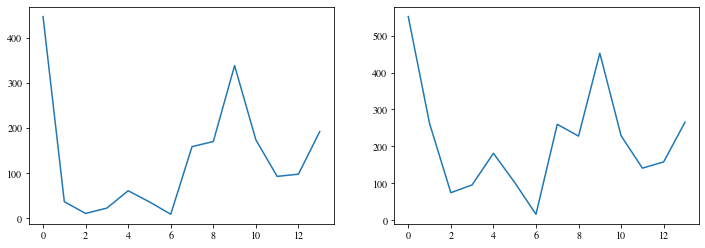

In [313]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(SECOND_RUN.ESS_SMC[1:])
ax[1].plot(SECOND_RUN.ESS[1:])
plt.show()

Do the same but for $5000$ particles

In [371]:
FIRST_RUN10k = MSAdaptive(generate_settings(d=d, N=10000, B=5,
    δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
    z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='prior',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, εmin=500.0))
_ = FIRST_RUN10k.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 70606773.8396144509315491
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7297000000000000
	Particle Diversity: 12.0540000000000003
	Moved Diversity: 8.7958037999999998
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 5969976.1147064408287406
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8308000000000000
	Particle Diversity: 12.0160000000000000
	Moved Diversity: 9.9828928000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 1360340.9406054175924510
	Weights compu

In [372]:
SECOND_RUN10k = MSAdaptive(generate_settings(d=d, N=10000, B=20,
    δ=0.1, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=np.array([*FIRST_RUN10k.εs, 200]), adaptiveε=False, adaptiveδ=True,
    z0_manual=FIRST_RUN10k.starting_particles, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='manual',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method='ap', εmin=200.0, proxy_ap_metric='pm'))
SECOND_PARTICLES10k = SECOND_RUN10k.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 70606773.8396144509315491
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0988000000000000
	Particle Diversity: 12.1319999999999997
	Moved Diversity: 1.1986416000000000
	Step-size adapted to: 0.0936505391537791 with strategy ap
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 5969976.1147064408287406
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8885000000000000
	Particle Diversity: 7.3419999999999996
	Moved Diversity: 6.5233669999999995
	Step-size adapted to: 0.1301672531178237 with strategy ap
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 1360340.9406054175924510
	Weights computed and normalized.
	SMC Weights compu

# The need to adapt $B$ and $\delta$

To show the need to adapt $B$ and $\delta$ run MS with $\delta$ fixed and a fairly large $B$, for a suitable step size. We will then grab ESJD-BR and show how this has a maximum at different $k\in\{0, T\}$ as the iteration progresses.

In [14]:
LOL = MSAdaptive(generate_settings(d=d, N=N, B=B,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None))
_ = LOL.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.4057200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.1886107756514690
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3920000000000000
	Moved Diversity: 0.3825920000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.8030587859000846
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9680000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.38

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.3560960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  27
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6182806201689122
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8280000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.3361680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  28
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4779304154824833
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8020000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.3288200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  29
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3367060740548533
	Weights computed and 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4740000000000000
	Particle Diversity: 0.4540000000000000
	Moved Diversity: 0.2151960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  53
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8859374314814383
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5080000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.2194560000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  54
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8689133822522641
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4560000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2006400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  55
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8543961095220696
	Weights computed and 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4760000000000000
	Particle Diversity: 0.4680000000000000
	Moved Diversity: 0.2227680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  79
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2211639842578554
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5300000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.2257800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  80
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1877591053503813
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5500000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2387000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  81
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1514942911846893
	Weights computed and 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.0760760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  105
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7258403435179728
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3120000000000000
	Particle Diversity: 0.3000000000000000
	Moved Diversity: 0.0936000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  106
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7152125575341326
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2240000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.0918400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  107
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7017069431365826
	Weights computed a

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1100000000000000
	Particle Diversity: 0.1620000000000000
	Moved Diversity: 0.0178200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  131
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5369165454866824
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0640000000000000
	Particle Diversity: 0.1200000000000000
	Moved Diversity: 0.0076800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  132
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5333265117757682
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0600000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.0267600000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5242440666853849
	Weights computed a

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Particle Diversity: 0.0940000000000000
	Moved Diversity: 0.0240640000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  157
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4034690989029133
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0300000000000000
	Particle Diversity: 0.3580000000000000
	Moved Diversity: 0.0107400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  158
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4001794707255762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0720000000000000
	Particle Diversity: 0.1960000000000000
	Moved Diversity: 0.0141120000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  159
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3967064515090321
	Weights computed a

Now plot snapshows of the ESJD at different run iterations

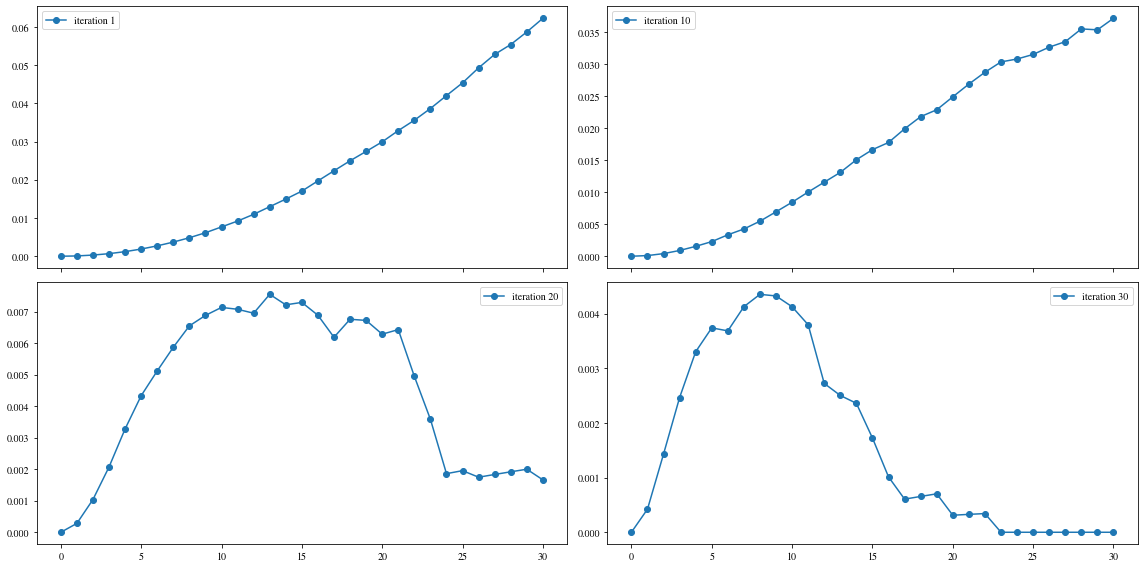

In [199]:
rc('font',**{'family':'STIXGeneral'})
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True)
# (0, 0) iteration 1
ax[0, 0].plot(np.arange(B+1), LOL.ESJD_CHANG[1], marker='o', label="iteration 1")
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[0, 0].hist(LOL.K_RESAMPLED[1], density=True, edgecolor='k', color='lightsalmon')
# ax[0, 0].set_xticks(np.arange(LOL.B+1))
ax[0, 0].legend()
# (0, 1) iteration 25
ax[0, 1].plot(np.arange(B+1), LOL.ESJD_CHANG[10], marker='o', label='iteration 10')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[0, 1].hist(LOL.K_RESAMPLED[10], density=True, edgecolor='k', color='lightsalmon')
# ax[0, 1].set_xticks(np.arange(LOL.B+1))
ax[0, 1].legend()
# (1, 0) iteration 75
ax[1, 0].plot(np.arange(B+1), LOL.ESJD_CHANG[20], marker='o', label='iteration 20')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[1, 0].hist(LOL.K_RESAMPLED[20], density=True, edgecolor='k', color='lightsalmon')
# ax[1, 0].set_xticks(np.arange(LOL.B+1))
ax[1, 0].legend()
# (1, 1) iteration 100
ax[1, 1].plot(np.arange(B+1), LOL.ESJD_CHANG[30], marker='o', label='iteration 30')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[1, 1].hist(LOL.K_RESAMPLED[30], density=True, edgecolor='k', color='lightsalmon')
# ax[1, 1].set_xticks(np.arange(LOL.B+1))
ax[1, 1].legend()
plt.tight_layout()
plt.show()

In the plots above we can see that indeed there is a maximum Expected Squared Jump Distance, which explains the need for adapting $B$ and $\delta$.

Let's try to get a similar plot but now let's run the algorithm with larger $B$ to see what happens at the very beginning. 

In [201]:
LOL_LONG = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None))
_ = LOL_LONG.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.3396479999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.9341338734060614
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9800000000000000
	Particle Diversity: 0.3120000000000000
	Moved Diversity: 0.3057600000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.1051403329597704
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.3386399999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8422490527730018
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8440000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.3494159999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6184662665673741
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8159999999999999
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.3394560000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Trajectories constructed.
	Epsilon: 0.9803243606877594
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4160000000000000
	Particle Diversity: 0.4520000000000000
	Moved Diversity: 0.1880320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9481034615692534
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4140000000000000
	Particle Diversity: 0.4480000000000000
	Moved Diversity: 0.1854720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9238526484170677
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3380000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.1493960

	Trajectories constructed.
	Epsilon: 0.7138322472828209
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0340000000000000
	Particle Diversity: 0.5080000000000000
	Moved Diversity: 0.0172720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7111114429874437
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0320000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.0136320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7065708608478120
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0640000000000000
	Particle Diversity: 0.2640000000000000
	Moved Diversity: 0.0168960

AttributeError: 'Rectangle' object has no property 'marker'

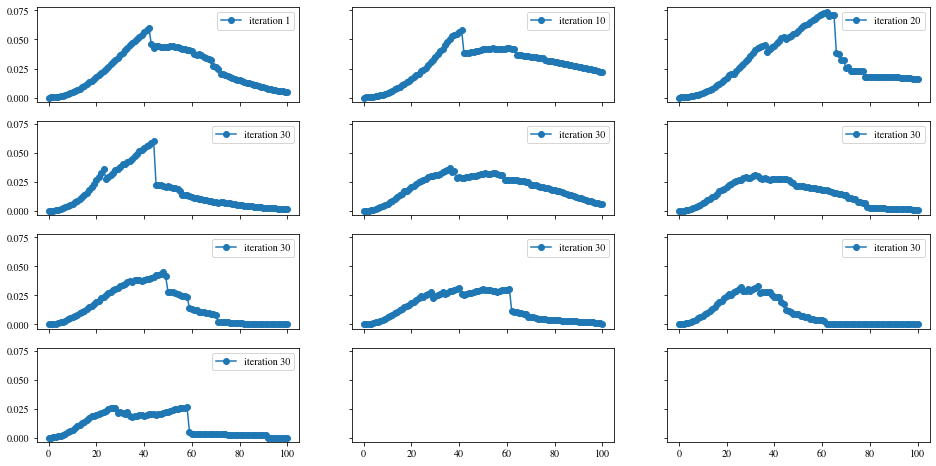

In [218]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX1], marker='o', label="iteration 1")
ax[0, 0].legend()

ax[0, 1].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX2], marker='o', label='iteration 10')
ax[0, 1].legend()

ax[0, 2].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX3], marker='o', label='iteration 20')
ax[0, 2].legend()

ax[1, 0].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX4], marker='o', label='iteration 30')
ax[1, 0].legend()

ax[1, 1].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX5], marker='o', label='iteration 30')
ax[1, 1].legend()

ax[1, 2].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX6], marker='o', label='iteration 30')
ax[1, 2].legend()

ax[2, 0].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX7], marker='o', label='iteration 30')
ax[2, 0].legend()

ax[2, 1].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX8], marker='o', label='iteration 30')
ax[2, 1].legend()

ax[2, 2].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX9], marker='o', label='iteration 30')
ax[2, 2].legend()

ax[3, 0].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX10], marker='o', label='iteration 30')
ax[3, 0].legend()

ax[3, 1].pl0t(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX11], marker='o', label='iteration 30')
ax[3, 1].legend()

ax[3, 2].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX12], marker='o', label='iteration 30')
ax[3, 2].legend()

plt.tight_layout()
# plt.savefig("figures/gk20_esjd_over_k_for_B100.png")
plt.show()

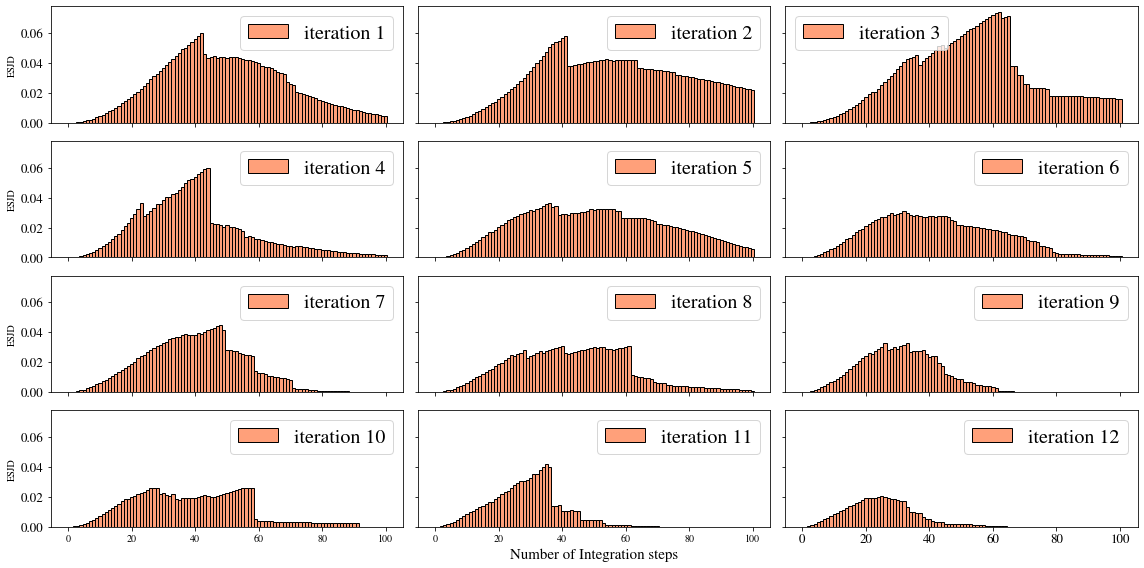

In [255]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX1], width=1.0, edgecolor='k', color='lightsalmon', label="iteration 1")
ax[0, 0].legend(fontsize=20)
ax[0, 0].yaxis.set_tick_params(labelsize=13) 
ax[0, 0].set_ylabel("ESJD")

ax[0, 1].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX2], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 2')
ax[0, 1].legend(fontsize=20)

ax[0, 2].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX3], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 3')
ax[0, 2].legend(fontsize=20)
ax[0, 2].xaxis.set_tick_params(labelsize=13) 

ax[1, 0].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX4], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 4')
ax[1, 0].legend(fontsize=20)
ax[1, 0].yaxis.set_tick_params(labelsize=13) 
ax[1, 0].set_ylabel("ESJD")

ax[1, 1].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX5], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 5')
ax[1, 1].legend(fontsize=20)

ax[1, 2].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX6], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 6')
ax[1, 2].legend(fontsize=20)
ax[1, 2].xaxis.set_tick_params(labelsize=13) 

ax[2, 0].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX7], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 7')
ax[2, 0].legend(fontsize=20)
ax[2, 0].yaxis.set_tick_params(labelsize=13) 
ax[2, 0].set_ylabel("ESJD")

ax[2, 1].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX8], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 8')
ax[2, 1].legend(fontsize=20)

ax[2, 2].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX9], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 9')
ax[2, 2].legend(fontsize=20)
ax[2, 2].xaxis.set_tick_params(labelsize=13) 

ax[3, 0].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX10], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 10')
ax[3, 0].legend(fontsize=20)
ax[3, 0].yaxis.set_tick_params(labelsize=13) 
ax[3, 0].set_ylabel("ESJD")

ax[3, 1].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX11], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 11')
ax[3, 1].legend(fontsize=20)
ax[3, 1].set_xlabel("Number of Integration steps", fontsize=15)

ax[3, 2].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX12], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 12')
ax[3, 2].legend(fontsize=20)
ax[3, 2].xaxis.set_tick_params(labelsize=13) 

plt.tight_layout()
plt.savefig("figures/gk20_esjd_over_k_for_B100_firstfew.png")
plt.show()

The epsilons for this setting are shown below.

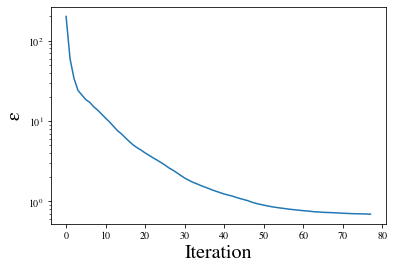

In [258]:
fig, ax = plt.subplots()
ax.plot(LOL_LONG.εs)
ax.set_yscale('log')
ax.set_ylabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_xlabel("Iteration", fontsize=20)
plt.show()

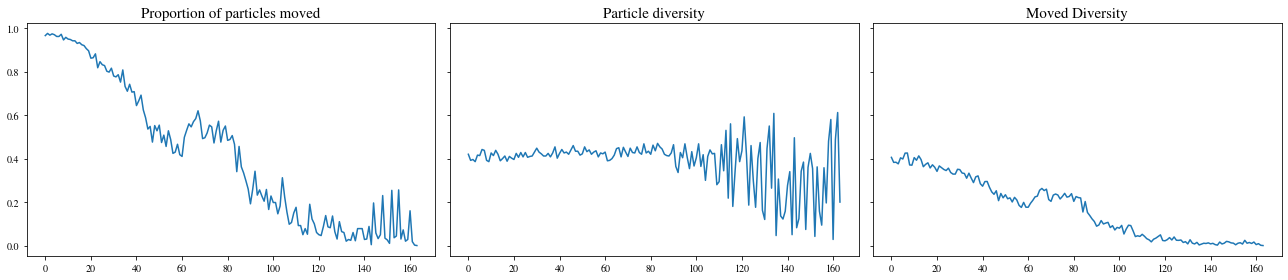

In [259]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharex=True, sharey=True)
ax[0].plot(LOL.PROP_MOVED[1:])
ax[0].set_title("Proportion of particles moved", fontsize=15)
ax[1].plot(LOL.P_DIVERSITY[1:])
ax[1].set_title("Particle diversity", fontsize=15)
ax[2].plot(LOL.DIV_MOVED[1:])
ax[2].set_title("Moved Diversity", fontsize=15)
plt.tight_layout()
plt.show()

# Adapting $B$ and $\delta$ based on ESJD and PM

In [178]:
LOL2 = MSAdaptive(generate_settings(d=d, N=N, B=B,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd_and_pm', adaptiveB=True,
        Bmin=5, Bmax=100))
_ = LOL2.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	 RWM Integrator with B = 30 and δ = 0.010000
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.4057200000000000
	Increasing B=43 and keeping δ=0.01 fixed.
	Step-size adapted to: 0.0100000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 43
Iteration:  2
	Quantile Value:  0.5
	 RWM Integrator with B = 43 and δ = 0.010000
	Trajectories constructed.
	Epsilon: 33.1886107756514690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Particle Diversity: 0.3660000000000000
	Moved Diversity: 0.3550200000000000
	Increasing B=62 and keeping δ=0.01 fixed.
	S

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1200000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.0552000000000000
	Step-size adapted to: 0.1808583570346251 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  19
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.180858
	Trajectories constructed.
	Epsilon: 7.1261947089418323
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1220000000000000
	Particle Diversity: 0.4660000000000000
	Moved Diversity: 0.0568520000000000
	Step-size adapted to: 0.1713510141837691 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  20
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.171351
	Trajectories constructed.
	Epsilon: 6.7154714128210946
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1280000000000000
	Particle Diversity: 0.2840000000000000
	Moved Diversity: 0.0363520000000000
	Step-size adapted to: 0.0728727061072574 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  37
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.072873
	Trajectories constructed.
	Epsilon: 2.6034321004071872
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0980000000000000
	Particle Diversity: 0.2620000000000000
	Moved Diversity: 0.0256760000000000
	Step-size adapted to: 0.0682183893514560 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  38
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.068218
	Trajectories constructed.
	Epsilon: 2.4409699630877331
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0900000000000000
	Particle Diversity: 0.4700000000000000
	Moved Diversity: 0.0423000000000000
	Step-size adapted to: 0.0226399074875543 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  55
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.022640
	Trajectories constructed.
	Epsilon: 1.5947934789834053
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0920000000000000
	Particle Diversity: 0.3500000000000000
	Moved Diversity: 0.0322000000000000
	Step-size adapted to: 0.0211304296926367 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  56
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.021130
	Trajectories constructed.
	Epsilon: 1.5720564801657961
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0860000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.0378400000000000
	Step-size adapted to: 0.0096091346018231 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  73
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.009609
	Trajectories constructed.
	Epsilon: 1.3882971207318586
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2020000000000000
	Particle Diversity: 0.3540000000000000
	Moved Diversity: 0.0715080000000000
	Step-size adapted to: 0.0094755440333491 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  74
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.009476
	Trajectories constructed.
	Epsilon: 1.3820522498835817
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1920000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.0879360000000000
	Step-size adapted to: 0.0053855215974018 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  91
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.005386
	Trajectories constructed.
	Epsilon: 1.3333843089381459
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2140000000000000
	Particle Diversity: 0.3460000000000000
	Moved Diversity: 0.0740440000000000
	Step-size adapted to: 0.0053426093026669 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  92
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.005343
	Trajectories constructed.
	Epsilon: 1.3310510841252636
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1500000000000000
	Particle Diversity: 0.3600000000000000
	Moved Diversity: 0.0540000000000000
	Step-size adapted to: 0.0056446837166107 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  109
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.005645
	Trajectories constructed.
	Epsilon: 1.2835956283041616
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1880000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.0815920000000000
	Step-size adapted to: 0.0055273813443016 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  110
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.005527
	Trajectories constructed.
	Epsilon: 1.2807909131541864
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2600000000000000
	Particle Diversity: 0.3640000000000000
	Moved Diversity: 0.0946400000000000
	Step-size adapted to: 0.0044848908883506 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  127
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004485
	Trajectories constructed.
	Epsilon: 1.2437752245267226
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1740000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.0734280000000000
	Step-size adapted to: 0.0043610557262050 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  128
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004361
	Trajectories constructed.
	Epsilon: 1.2423983438138000
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2060000000000000
	Particle Diversity: 0.4520000000000000
	Moved Diversity: 0.0931120000000000
	Step-size adapted to: 0.0040177183508648 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  145
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004018
	Trajectories constructed.
	Epsilon: 1.2065058130759494
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2100000000000000
	Particle Diversity: 0.3920000000000000
	Moved Diversity: 0.0823200000000000
	Step-size adapted to: 0.0039777413853247 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  146
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003978
	Trajectories constructed.
	Epsilon: 1.2049079571498846
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1780000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.0818800000000000
	Step-size adapted to: 0.0034236737385050 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  163
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003424
	Trajectories constructed.
	Epsilon: 1.1822114706516194
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1540000000000000
	Particle Diversity: 0.3660000000000000
	Moved Diversity: 0.0563640000000000
	Step-size adapted to: 0.0032960150134481 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  164
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003296
	Trajectories constructed.
	Epsilon: 1.1813359621615778
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2300000000000000
	Particle Diversity: 0.3680000000000000
	Moved Diversity: 0.0846400000000000
	Step-size adapted to: 0.0031415432720321 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  181
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003142
	Trajectories constructed.
	Epsilon: 1.1641666105867530
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.0889440000000000
	Step-size adapted to: 0.0031227504472527 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  182
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003123
	Trajectories constructed.
	Epsilon: 1.1632401756892770
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1240000000000000
	Particle Diversity: 0.5300000000000000
	Moved Diversity: 0.0657200000000000
	Step-size adapted to: 0.0027946703784819 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  199
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.002795
	Trajectories constructed.
	Epsilon: 1.1455806925964276
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1940000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.0849720000000000
	Step-size adapted to: 0.0027448163440310 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  200
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.002745
	Trajectories constructed.
	Epsilon: 1.1447690515314042
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2400000000000000
	Particle Diversity: 0.3720000000000000
	Moved Diversity: 0.0892800000000000
	Step-size adapted to: 0.0045344970216615 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  217
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004534
	Trajectories constructed.
	Epsilon: 1.1085282124379090
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2760000000000000
	Particle Diversity: 0.4440000000000000
	Moved Diversity: 0.1225440000000000
	Step-size adapted to: 0.0046399990759427 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  218
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004640
	Trajectories constructed.
	Epsilon: 1.1052731158900531
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2880000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1146240000000000
	Step-size adapted to: 0.0071471535109898 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  235
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.007147
	Trajectories constructed.
	Epsilon: 1.0198545915133819
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2440000000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.1005280000000000
	Step-size adapted to: 0.0071973591001227 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  236
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.007197
	Trajectories constructed.
	Epsilon: 1.0106609713125136
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2020000000000000
	Particle Diversity: 0.3840000000000000
	Moved Diversity: 0.0775680000000000
	Step-size adapted to: 0.0086513395228536 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  253
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.008651
	Trajectories constructed.
	Epsilon: 0.8032102547070250
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1320000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.0588720000000000
	Increasing B=5 and keeping δ=0.008651339522853579 fixed.
	Step-size adapted to: 0.0086513395228536 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  254
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.008651
	Trajectories constructed.
	Epsilon: 0.7923748232593502
	Weights compu

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1300000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.0546000000000000
	Step-size adapted to: 0.0063771045820935 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  271
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.006377
	Trajectories constructed.
	Epsilon: 0.5937744702018923
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3240000000000000
	Particle Diversity: 0.2520000000000000
	Moved Diversity: 0.0816480000000000
	Step-size adapted to: 0.0066839836666949 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  272
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.006684
	Trajectories constructed.
	Epsilon: 0.5853384162964843
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1480000000000000
	Particle Diversity: 0.3540000000000000
	Moved Diversity: 0.0523920000000000
	Increasing B=5 and keeping δ=0.003879530600592494 fixed.
	Step-size adapted to: 0.0038795306005925 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  289
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003880
	Trajectories constructed.
	Epsilon: 0.5096490463682085
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.0728000000000000
	Step-size adapted to: 0.0037875302859270 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  290
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003788
	Trajectories constructed.
	Epsilon: 0.5066492555810418
	Weights compu

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1360000000000000
	Particle Diversity: 0.4540000000000000
	Moved Diversity: 0.0617440000000000
	Step-size adapted to: 0.0030426053368498 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  307
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003043
	Trajectories constructed.
	Epsilon: 0.4552752778798773
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1560000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.0624000000000000
	Step-size adapted to: 0.0029320861524078 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  308
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.002932
	Trajectories constructed.
	Epsilon: 0.4533817828923647
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2960000000000000
	Particle Diversity: 0.3380000000000000
	Moved Diversity: 0.1000480000000000
	Step-size adapted to: 0.0020890599228080 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  325
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.002089
	Trajectories constructed.
	Epsilon: 0.4272979524238942
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1400000000000000
	Particle Diversity: 0.4760000000000000
	Moved Diversity: 0.0666400000000000
	Step-size adapted to: 0.0019971360256029 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  326
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001997
	Trajectories constructed.
	Epsilon: 0.4264252292613051
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1420000000000000
	Particle Diversity: 0.3560000000000000
	Moved Diversity: 0.0505520000000000
	Step-size adapted to: 0.0015352821375104 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  343
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001535
	Trajectories constructed.
	Epsilon: 0.4124028057095041
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.3520000000000000
	Moved Diversity: 0.0767360000000000
	Step-size adapted to: 0.0015260980245765 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  344
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001526
	Trajectories constructed.
	Epsilon: 0.4117393903841560
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2240000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.0985600000000000
	Step-size adapted to: 0.0015569272496851 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  361
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001557
	Trajectories constructed.
	Epsilon: 0.3993247010310311
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2480000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.1006880000000000
	Step-size adapted to: 0.0015710028400790 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  362
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001571
	Trajectories constructed.
	Epsilon: 0.3985377251700223
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2980000000000000
	Particle Diversity: 0.3260000000000000
	Moved Diversity: 0.0971480000000000
	Step-size adapted to: 0.0014899076930838 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  379
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001490
	Trajectories constructed.
	Epsilon: 0.3846800277410473
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2280000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.1026000000000000
	Step-size adapted to: 0.0014884185300963 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  380
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001488
	Trajectories constructed.
	Epsilon: 0.3838454795406727
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2260000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.0935640000000000
	Step-size adapted to: 0.0012836584524114 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  397
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001284
	Trajectories constructed.
	Epsilon: 0.3734706515717416
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1200000000000000
	Particle Diversity: 0.4720000000000000
	Moved Diversity: 0.0566400000000000
	Step-size adapted to: 0.0012149636602523 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  398
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001215
	Trajectories constructed.
	Epsilon: 0.3730738332364863
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2740000000000000
	Particle Diversity: 0.3840000000000000
	Moved Diversity: 0.1052160000000000
	Step-size adapted to: 0.0013400597025175 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  415
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001340
	Trajectories constructed.
	Epsilon: 0.3619546501201096
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2060000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.0927000000000000
	Step-size adapted to: 0.0013240750856037 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  416
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001324
	Trajectories constructed.
	Epsilon: 0.3614916573747987
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.3380000000000000
	Moved Diversity: 0.0736840000000000
	Step-size adapted to: 0.0011825985367502 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  433
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001183
	Trajectories constructed.
	Epsilon: 0.3520384414475489
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1900000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.0809400000000000
	Step-size adapted to: 0.0011591815167770 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  434
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001159
	Trajectories constructed.
	Epsilon: 0.3514435105268853
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3540000000000000
	Particle Diversity: 0.3300000000000000
	Moved Diversity: 0.1168200000000000
	Step-size adapted to: 0.0011980726817434 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  451
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001198
	Trajectories constructed.
	Epsilon: 0.3409329771662409
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3600000000000000
	Particle Diversity: 0.3860000000000000
	Moved Diversity: 0.1389600000000000
	Step-size adapted to: 0.0012785340741907 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  452
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001279
	Trajectories constructed.
	Epsilon: 0.3401753338310944
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2020000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.0803960000000000
	Step-size adapted to: 0.0011603412780778 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  469
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001160
	Trajectories constructed.
	Epsilon: 0.3279711335358007
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2100000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.0919800000000000
	Step-size adapted to: 0.0011487956894532 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  470
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001149
	Trajectories constructed.
	Epsilon: 0.3275398435678551
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2580000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.1037160000000000
	Step-size adapted to: 0.0010800420763926 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  487
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001080
	Trajectories constructed.
	Epsilon: 0.3198074705355859
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Particle Diversity: 0.3800000000000000
	Moved Diversity: 0.0972800000000000
	Step-size adapted to: 0.0010941742837052 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  488
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001094
	Trajectories constructed.
	Epsilon: 0.3192795046294498
	Weights computed and normalized.
	SMC Weights computed and normalized.


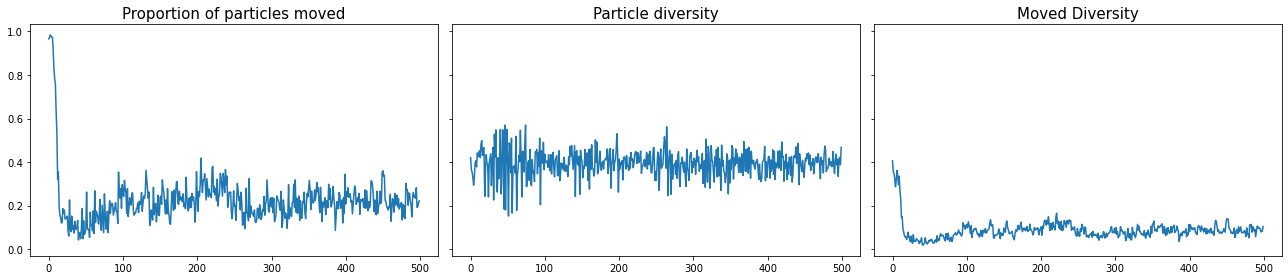

In [179]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharex=True, sharey=True)
ax[0].plot(LOL2.PROP_MOVED[1:])
ax[0].set_title("Proportion of particles moved", fontsize=15)
ax[1].plot(LOL2.P_DIVERSITY[1:])
ax[1].set_title("Particle diversity", fontsize=15)
ax[2].plot(LOL2.DIV_MOVED[1:])
ax[2].set_title("Moved Diversity", fontsize=15)
plt.tight_layout()
plt.show()

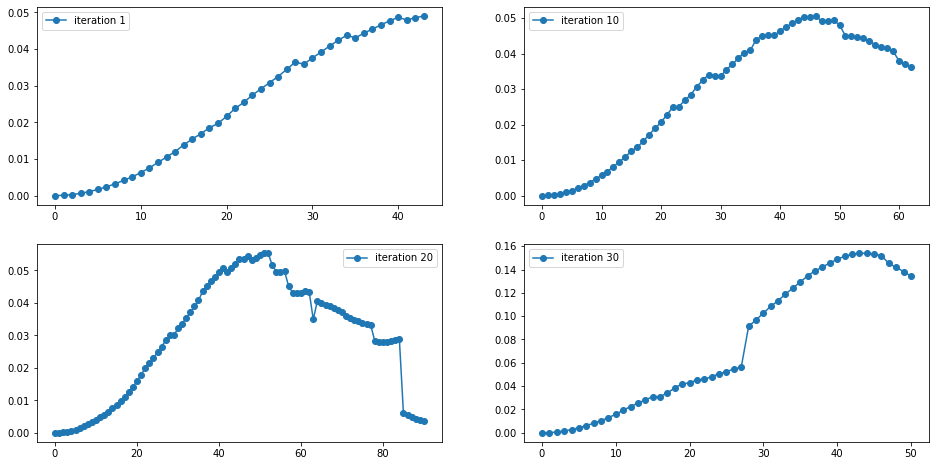

In [186]:
index1 = 1
index2 = 2
index3 = 3
index4 = 4
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
# (0, 0) iteration 1
ax[0, 0].plot(np.arange(LOL2.Bs[index1]+1), LOL2.ESJD_CHANG[1:][index1], marker='o', label="iteration 1")
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[0, 0].hist(LOL.K_RESAMPLED[index1], density=True, edgecolor='k', color='lightsalmon')
# ax[0, 0].set_xticks(np.arange(LOL.B+1))
ax[0, 0].legend()
# (0, 1) iteration 25
ax[0, 1].plot(np.arange(LOL2.Bs[index2]+1), LOL2.ESJD_CHANG[1:][index2], marker='o', label='iteration 10')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[0, 1].hist(LOL.K_RESAMPLED[index2], density=True, edgecolor='k', color='lightsalmon')
# ax[0, 1].set_xticks(np.arange(LOL.B+1))
ax[0, 1].legend()
# (1, 0) iteration 75
ax[1, 0].plot(np.arange(LOL2.Bs[index3]+1), LOL2.ESJD_CHANG[1:][index3], marker='o', label='iteration 20')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[1, 0].hist(LOL.K_RESAMPLED[index3], density=True, edgecolor='k', color='lightsalmon')
# ax[1, 0].set_xticks(np.arange(LOL.B+1))
ax[1, 0].legend()
# (1, 1) iteration 100
ax[1, 1].plot(np.arange(LOL2.Bs[index4]+1), LOL2.ESJD_CHANG[1:][index4], marker='o', label='iteration 30')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[1, 1].hist(LOL.K_RESAMPLED[index4], density=True, edgecolor='k', color='lightsalmon')
# ax[1, 1].set_xticks(np.arange(LOL.B+1))
ax[1, 1].legend()
plt.show()

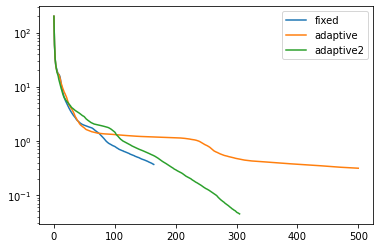

In [191]:
fig, ax = plt.subplots()
ax.plot(LOL.εs, label='fixed')
ax.plot(LOL2.εs, label='adaptive')
ax.plot(LOL3.εs, label='adaptive2')
ax.set_yscale('log')
ax.legend()
plt.show()

In [189]:
LOL3 = MSAdaptive(generate_settings(d=d, N=N, B=B,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd_and_pm', adaptiveB=True,
        Bmin=5, Bmax=100))
_ = LOL3.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.4057200000000000
	Step-size adapted to: 0.0144484203897388 with strategy esjd_and_pm
	Number of steps adapted to: 30
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.1886107756514690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3666600000000000
	Step-size adapted to: 0.0209174783254322 with strategy esjd_and_pm
	Number of steps adapted to: 30
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.9020

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0320000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.0139520000000000
	Step-size adapted to: 0.1100596464826380 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  22
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.2379696533497926
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0720000000000000
	Particle Diversity: 0.5520000000000000
	Moved Diversity: 0.0397440000000000
	Step-size adapted to: 0.1016995074202697 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  23
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.0599136191381815
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0960000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3980000000000000
	Particle Diversity: 0.1760000000000000
	Moved Diversity: 0.0700480000000000
	Step-size adapted to: 0.0491080248125934 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  42
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2428156866898026
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1460000000000000
	Particle Diversity: 0.3520000000000000
	Moved Diversity: 0.0513920000000000
	Step-size adapted to: 0.0470882009763995 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  43
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1734579079718008
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2860000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1900000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.0752400000000000
	Step-size adapted to: 0.0287610620324045 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  62
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1558891029580729
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.3320000000000000
	Moved Diversity: 0.0723760000000000
	Step-size adapted to: 0.0285890123254796 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  63
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1272336146746165
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1320000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2900000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.1009200000000000
	Step-size adapted to: 0.0132768572022583 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  82
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8650336259623588
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2000000000000000
	Particle Diversity: 0.4920000000000000
	Moved Diversity: 0.0984000000000000
	Step-size adapted to: 0.0130791905503496 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  83
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8514226890966741
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2320000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2920000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.1249760000000000
	Step-size adapted to: 0.0191063828448285 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3374624146177565
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2200000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.0915200000000000
	Step-size adapted to: 0.0190110893628373 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2934035597147271
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2100000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1980000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.0744480000000000
	Step-size adapted to: 0.0101454208873099 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8866841890686348
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1800000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.0784800000000000
	Step-size adapted to: 0.0098949295530926 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  123
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8752367910739605
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1400000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1780000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.0669280000000000
	Step-size adapted to: 0.0065996885569910 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  142
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6876669992778709
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.4660000000000000
	Moved Diversity: 0.0848120000000000
	Step-size adapted to: 0.0064431816270431 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  143
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6798239856679480
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1700000000000000
	Particle Diversity: 0.3900000000000000
	Moved Diversity: 0.0663000000000000
	Step-size adapted to: 0.0050431075002033 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5484054298533596
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1880000000000000
	Particle Diversity: 0.3820000000000000
	Moved Diversity: 0.0718160000000000
	Step-size adapted to: 0.0049383065045615 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5422710230395273
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2200000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2840000000000000
	Particle Diversity: 0.3040000000000000
	Moved Diversity: 0.0863360000000000
	Step-size adapted to: 0.0046090532151110 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  182
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3951784476752459
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1380000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.0552000000000000
	Step-size adapted to: 0.0044018392264010 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  183
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3887284025369460
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1380000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2440000000000000
	Particle Diversity: 0.3700000000000000
	Moved Diversity: 0.0902800000000000
	Step-size adapted to: 0.0034904213499940 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  202
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2852399368350662
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1120000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.0463680000000000
	Step-size adapted to: 0.0032904438338498 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  203
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2803339813078723
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1640000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.0760760000000000
	Step-size adapted to: 0.0022524588901867 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  222
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2094540914297515
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1440000000000000
	Particle Diversity: 0.3180000000000000
	Moved Diversity: 0.0457920000000000
	Step-size adapted to: 0.0021576560265676 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  223
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2076380571355483
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1980000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2000000000000000
	Particle Diversity: 0.3380000000000000
	Moved Diversity: 0.0676000000000000
	Step-size adapted to: 0.0017298288268279 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  242
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1512692759211098
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2360000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.0991200000000000
	Step-size adapted to: 0.0017350261053282 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  243
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1482612894655984
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3240000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2240000000000000
	Particle Diversity: 0.3580000000000000
	Moved Diversity: 0.0801920000000000
	Step-size adapted to: 0.0012436149983813 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  262
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1081844579863711
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.1044480000000000
	Step-size adapted to: 0.0012598875356818 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  263
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1062451687824844
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2720000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1780000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.0801000000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  282
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0696515275174148
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2120000000000000
	Particle Diversity: 0.3380000000000000
	Moved Diversity: 0.0716560000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  283
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0681401594291297
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1940000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0120000000000000
	Particle Diversity: 0.5900000000000000
	Moved Diversity: 0.0070800000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  302
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0472436056340810
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1160000000000000
	Particle Diversity: 0.1320000000000000
	Moved Diversity: 0.0153120000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  303
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0466154165338100
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0060000000000000
	Particle Div

In [197]:
LOL4 = MSAdaptive(generate_settings(d=d, N=N, B=B,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.01, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd_and_pm', adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='dm'))
_ = LOL4.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.4057200000000000
	Step-size adapted to: 0.0121879175103178 with strategy esjd_and_pm
	Number of steps adapted to: 30
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.1886107756514690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9580000000000000
	Particle Diversity: 0.3680000000000000
	Moved Diversity: 0.3525440000000000
	Step-size adapted to: 0.0144647852623904 with strategy esjd_and_pm
	Number of steps adapted to: 30
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.7682

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1280000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.0524800000000000
	Step-size adapted to: 0.1475765601515626 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  22
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.7785093853914180
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0920000000000000
	Particle Diversity: 0.4780000000000000
	Moved Diversity: 0.0439760000000000
	Step-size adapted to: 0.1501050065721249 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  23
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5353014310922202
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1140000000000000
	Particle Diver

# Adapt B and $\delta$ but first start from huge B so we only need to decrease it

In [260]:
# adapt B and δ based on EJSD and PM
LOL_LONG_ADAPT = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd_and_pm', adaptiveB=True,
        Bmin=5, Bmax=100))
_ = LOL_LONG_ADAPT.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.3396479999999999
	Step-size adapted to: 0.0105635467989005 with strategy esjd_and_pm
	Number of steps adapted to: 80
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.9341338734060614
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9820000000000000
	Particle Diversity: 0.2940000000000000
	Moved Diversity: 0.2887080000000000
	Step-size adapted to: 0.0108782250898316 with strategy esjd_and_pm
	Number of steps adapted to: 71
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.6848

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7100000000000000
	Particle Diversity: 0.3840000000000000
	Moved Diversity: 0.2726400000000000
	Step-size adapted to: 0.0314390607576446 with strategy esjd_and_pm
	Number of steps adapted to: 10
Iteration:  22
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.0321293728467893
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7400000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.2989600000000000
	Step-size adapted to: 0.0325419847142750 with strategy esjd_and_pm
	Number of steps adapted to: 9
Iteration:  23
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.5245570937149511
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7220000000000000
	Particle Dive

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3900000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1638000000000000
	Step-size adapted to: 0.0253820718719271 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  42
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7048070550362282
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4480000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1881600000000000
	Step-size adapted to: 0.0248565945850839 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  43
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6553299385099800
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3700000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5020000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.2088320000000000
	Step-size adapted to: 0.0147474338738176 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  62
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0923670824880478
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4740000000000000
	Particle Diversity: 0.4440000000000000
	Moved Diversity: 0.2104560000000000
	Step-size adapted to: 0.0146040237928658 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  63
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0735990213664728
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4820000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6020000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.2540440000000000
	Step-size adapted to: 0.0147049047264385 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  82
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2681556942744088
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5280000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2291520000000000
	Step-size adapted to: 0.0146986711684422 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  83
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2203881011974937
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5220000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4500000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.1881000000000000
	Step-size adapted to: 0.0108387436840976 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7496044445172056
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3660000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.1588440000000000
	Step-size adapted to: 0.0104599020358358 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7355766461969897
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4160000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4060000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.1778280000000000
	Step-size adapted to: 0.0062189251913047 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5451903338903699
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4340000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.1857520000000000
	Step-size adapted to: 0.0060828485209244 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  123
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5391618329915273
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4340000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4640000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.2050880000000000
	Step-size adapted to: 0.0039415777723808 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  142
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4468592570345895
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5100000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.2111400000000000
	Step-size adapted to: 0.0039045833966120 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  143
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4417992484431155
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4820000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Particle Diversity: 0.4440000000000000
	Moved Diversity: 0.2326560000000000
	Step-size adapted to: 0.0032147483888501 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3682503004748916
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5100000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.2233800000000000
	Step-size adapted to: 0.0032041251628212 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3643540218001196
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4960000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5180000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2248120000000000
	Step-size adapted to: 0.0028167876177556 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  182
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3152805422535070
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4940000000000000
	Particle Diversity: 0.4300000000000000
	Moved Diversity: 0.2124200000000000
	Step-size adapted to: 0.0027921365547375 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  183
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3127196767892904
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4320000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5500000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.2244000000000000
	Step-size adapted to: 0.0027083107281782 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  202
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2584152969539419
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4700000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.1927000000000000
	Step-size adapted to: 0.0026582688243178 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  203
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2554363147618528
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5700000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.2382600000000000
	Step-size adapted to: 0.0025836912487256 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  222
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1968308438518545
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5060000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2226400000000000
	Step-size adapted to: 0.0025742007381800 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  223
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1934215369455936
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5280000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5160000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.2146560000000000
	Step-size adapted to: 0.0023964466865598 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  242
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1435869245263748
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5120000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.2119680000000000
	Step-size adapted to: 0.0023749374326543 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  243
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1407236951562605
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4900000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5320000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2276960000000000
	Step-size adapted to: 0.0021808988165415 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  262
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0964771661702650
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2242720000000000
	Step-size adapted to: 0.0021746616582050 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  263
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0928997540440222
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5540000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6740000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.2938640000000000
	Step-size adapted to: 0.0024558454799947 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  282
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0310798281381990
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5880000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.2681280000000000
	Step-size adapted to: 0.0025031128391461 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  283
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0252904372964640
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6200000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5860000000000000
	Particle Diversity: 0.4240000000000000
	Moved Diversity: 0.2484640000000000
	Step-size adapted to: 0.0037905953568362 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  302
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7758471538918995
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5780000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2473840000000000
	Step-size adapted to: 0.0038236868188312 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  303
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7602288690441719
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5960000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3460000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.1480880000000000
	Step-size adapted to: 0.0026487533437673 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  322
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6121226552637510
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4680000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.1890720000000000
	Step-size adapted to: 0.0025951001076271 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  323
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6078734200272123
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4840000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3660000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.1588440000000000
	Step-size adapted to: 0.0016343302591439 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  342
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5582102035656997
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4580000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.1914440000000000
	Step-size adapted to: 0.0016031253905486 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  343
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5565609932913231
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4260000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5480000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.2202960000000000
	Step-size adapted to: 0.0012191026959269 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  362
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5260814934075480
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5600000000000001
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.2419200000000000
	Step-size adapted to: 0.0012263902433138 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  363
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5245384121009437
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5500000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.2508000000000000
	Step-size adapted to: 0.0012507546548097 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  382
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4892689720400138
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5520000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2395680000000000
	Step-size adapted to: 0.0012567526007255 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  383
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4872081574040899
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5300000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6120000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.2607120000000000
	Step-size adapted to: 0.0013161451102794 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  402
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4434615067395827
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5600000000000001
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2396800000000000
	Step-size adapted to: 0.0013225306932585 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  403
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4411327529078103
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5580000000000001
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5340000000000000
	Particle Diversity: 0.4300000000000000
	Moved Diversity: 0.2296200000000000
	Step-size adapted to: 0.0012504295008713 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  422
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3988325996862295
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4700000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.1955200000000000
	Step-size adapted to: 0.0012290568578172 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  423
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3968050215764628
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4980000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5040000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.2026080000000000
	Step-size adapted to: 0.0010728547571187 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  442
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3608711236225194
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5500000000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.2266000000000000
	Step-size adapted to: 0.0010710324534286 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  443
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3592421392729244
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4540000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4900000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.2048200000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3291452167301748
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4900000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.2038400000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  463
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3280956377111894
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4820000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4360000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.1839920000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  482
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3054961209863006
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3920000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.1701280000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  483
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3044522446429346
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3980000000000000
	Particle Div

In [271]:
# adapt δ based on EJSD, but keep B fixed
LOL_LONG_ADAPT2 = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd', adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm'))
_ = LOL_LONG_ADAPT2.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.3396479999999999
	Step-size adapted to: 0.0085000000000000 with strategy esjd
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.9341338734060614
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.2700000000000000
	Moved Diversity: 0.2662200000000000
	Step-size adapted to: 0.0073100000000000 with strategy esjd
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 23.4588294723928961
	Weights computed and normalized.
	SMC Weights computed and norma

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9800000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.3861200000000000
	Step-size adapted to: 0.0018994378921675 with strategy esjd
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.1585303789783641
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9740000000000000
	Particle Diversity: 0.3860000000000000
	Moved Diversity: 0.3759640000000000
	Step-size adapted to: 0.0018044659975592 with strategy esjd
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.8467007787828313
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9740000000000000
	Particle Diversity: 0.3720000000000000
	Moved Diversity: 0.3623280000000000
	Step-size ada

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9780000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.4068480000000000
	Step-size adapted to: 0.0004744574414466 with strategy esjd
Iteration:  46
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3552512454997907
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.3918800000000000
	Step-size adapted to: 0.0004459899949598 with strategy esjd
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3247490243982538
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9840000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.3936000000000000
	Step-size ada

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.3932240000000000
	Step-size adapted to: 0.0001850978380583 with strategy esjd
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8406808849179750
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9780000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.3951120000000000
	Step-size adapted to: 0.0001758429461554 with strategy esjd
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8332963872940071
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.3669760000000000
	Step-size ada

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.4307680000000000
	Step-size adapted to: 0.0000853560039744 with strategy esjd
Iteration:  90
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6980572933924372
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.4001600000000000
	Step-size adapted to: 0.0000827953238552 with strategy esjd
Iteration:  91
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6923600530079044
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3900000000000000
	Moved Diversity: 0.3845400000000000
	Step-size ada

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9920000000000000
	Particle Diversity: 0.4240000000000000
	Moved Diversity: 0.4206080000000000
	Step-size adapted to: 0.0000464449262269 with strategy esjd
Iteration:  112
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6310519781199126
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.4208880000000000
	Step-size adapted to: 0.0000450515784401 with strategy esjd
Iteration:  113
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6289615363938879
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9720000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.4257360000000000
	Step-size a

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9900000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.4019400000000000
	Step-size adapted to: 0.0000285821291260 with strategy esjd
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5982476664640637
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.4327440000000000
	Step-size adapted to: 0.0000280104865435 with strategy esjd
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5965782879774058
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9800000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.4370800000000000
	Step-size a

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9820000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.4242240000000000
	Step-size adapted to: 0.0000183260236270 with strategy esjd
Iteration:  156
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5755358974699407
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9920000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.4543360000000000
	Step-size adapted to: 0.0000179595031544 with strategy esjd
Iteration:  157
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5749090483747277
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9840000000000000
	Particle Diversity: 0.4660000000000000
	Moved Diversity: 0.4585440000000000
	Step-size a

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.4446000000000000
	Step-size adapted to: 0.0000117501093252 with strategy esjd
Iteration:  178
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5623536666991362
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9920000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.4523520000000000
	Step-size adapted to: 0.0000115151071387 with strategy esjd
Iteration:  179
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5619342043513964
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9800000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.4488400000000000
	Step-size a

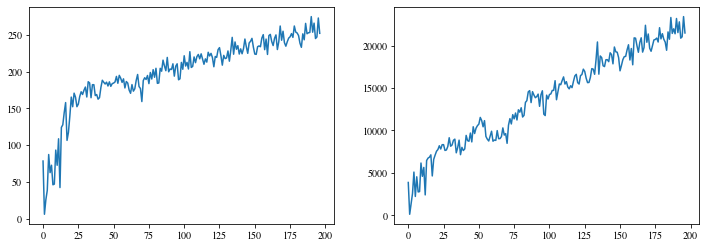

In [282]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(LOL_LONG_ADAPT2.ESS_SMC[1:])
ax[1].plot(LOL_LONG_ADAPT2.ESS[1:])
plt.show()

# Studying Adaptation

Start by only adapting $B$ and not adapting $\delta$. Let's see what happens.

In [471]:
# adapt δ based on EJSD, but keep B fixed (use prop_esjd=0.99)
ONLY_AB_99 = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.99))
ONLY_AB_PARTICLES_99 = ONLY_AB_99.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Number of steps adapted to: 90
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.8601940227620162
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9840000000000000
	Particle Diversity: 0.3660000000000000
	Moved Diversity: 0.3601440000000000
	Number of steps adapted to: 88
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 30.4104668925876851
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop 

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9140000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.3911920000000000
	Number of steps adapted to: 32
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.2649937852662685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9100000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.3712800000000000
	Number of steps adapted to: 31
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.8641420449982258
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8780000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.3599800000000000
	Number of steps adapted to: 28
Iteration:  27
	Quantile Value:  0.5
	Tr

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6840000000000001
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.2790720000000000
	Number of steps adapted to: 9
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2877714978414199
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6660000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.2757240000000000
	Number of steps adapted to: 8
Iteration:  50
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2243189900674363
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.2797200000000000
	Number of steps adapted to: 8
Iteration:  51
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2380000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.1004360000000000
	Number of steps adapted to: 5
Iteration:  73
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5792892483027599
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3300000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.1333200000000000
	Number of steps adapted to: 5
Iteration:  74
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5710349741385419
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2680000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1125600000000000
	Number of steps adapted to: 5
Iteration:  75
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1120000000000000
	Particle Diversity: 0.2760000000000000
	Moved Diversity: 0.0309120000000000
	Number of steps adapted to: 5
Iteration:  97
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3302337435462028
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0560000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.0257600000000000
	Number of steps adapted to: 5
Iteration:  98
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3260268402716788
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0760000000000000
	Particle Diversity: 0.4900000000000000
	Moved Diversity: 0.0372400000000000
	Number of steps adapted to: 5
Iteration:  99
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0120000000000000
	Particle Diversity: 0.6060000000000000
	Moved Diversity: 0.0072720000000000
	Number of steps adapted to: 5
Iteration:  121
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2451856249560436
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0180000000000000
	Particle Diversity: 0.6160000000000000
	Moved Diversity: 0.0110880000000000
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2405476944981739
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Particle Diversity: 0.0140000000000000
	Moved Diversity: 0.0000000000000000
	Number of steps adapted to: 5


In [340]:
# adapt δ based on EJSD, but keep B fixed
ONLY_AB_95 = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
ONLY_AB_PARTICLES_95 = ONLY_AB_95.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Number of steps adapted to: 75
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.8601940227620162
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9680000000000000
	Particle Diversity: 0.3800000000000000
	Moved Diversity: 0.3678400000000000
	Number of steps adapted to: 71
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 30.8388937902629685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop 

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8920000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.3621520000000000
	Number of steps adapted to: 24
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6634677624821723
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8520000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.3373920000000000
	Number of steps adapted to: 23
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.4090771111564564
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8500000000000000
	Particle Diversity: 0.3820000000000000
	Moved Diversity: 0.3247000000000000
	Number of steps adapted to: 23
Iteration:  27
	Quantile Value:  0.5
	Tr

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6240000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2670720000000000
	Number of steps adapted to: 6
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1184449902456222
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6580000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.2776760000000000
	Number of steps adapted to: 6
Iteration:  50
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.0686056415421645
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5720000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.2528240000000000
	Number of steps adapted to: 6
Iteration:  51
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3300000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.1366200000000000
	Number of steps adapted to: 5
Iteration:  73
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6097489229394339
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2660000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1058680000000000
	Number of steps adapted to: 5
Iteration:  74
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6013996164471886
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2720000000000000
	Particle Diversity: 0.4540000000000000
	Moved Diversity: 0.1234880000000000
	Number of steps adapted to: 5
Iteration:  75
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.0963560000000000
	Number of steps adapted to: 5
Iteration:  97
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4373386244767490
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1940000000000000
	Particle Diversity: 0.4720000000000000
	Moved Diversity: 0.0915680000000000
	Number of steps adapted to: 5
Iteration:  98
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4321358861001683
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2600000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.0904800000000000
	Number of steps adapted to: 5
Iteration:  99
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1600000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.0694400000000000
	Number of steps adapted to: 5
Iteration:  121
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2332075523398043
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1660000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.0654040000000000
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2264252925413686
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0900000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.0414000000000000
	Number of steps adapted to: 5
Iteration:  123
	Quantile Value:  0.5
	Tr

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0460000000000000
	Particle Diversity: 0.1100000000000000
	Moved Diversity: 0.0050600000000000
	Number of steps adapted to: 5
Iteration:  145
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1489597730706733
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0220000000000000
	Particle Diversity: 0.1120000000000000
	Moved Diversity: 0.0024640000000000
	Number of steps adapted to: 5
Iteration:  146
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1481677162642625
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0220000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.0089320000000000
	Number of steps adapted to: 5
Iteration:  147
	Quantile Value:  0.5
	Tr

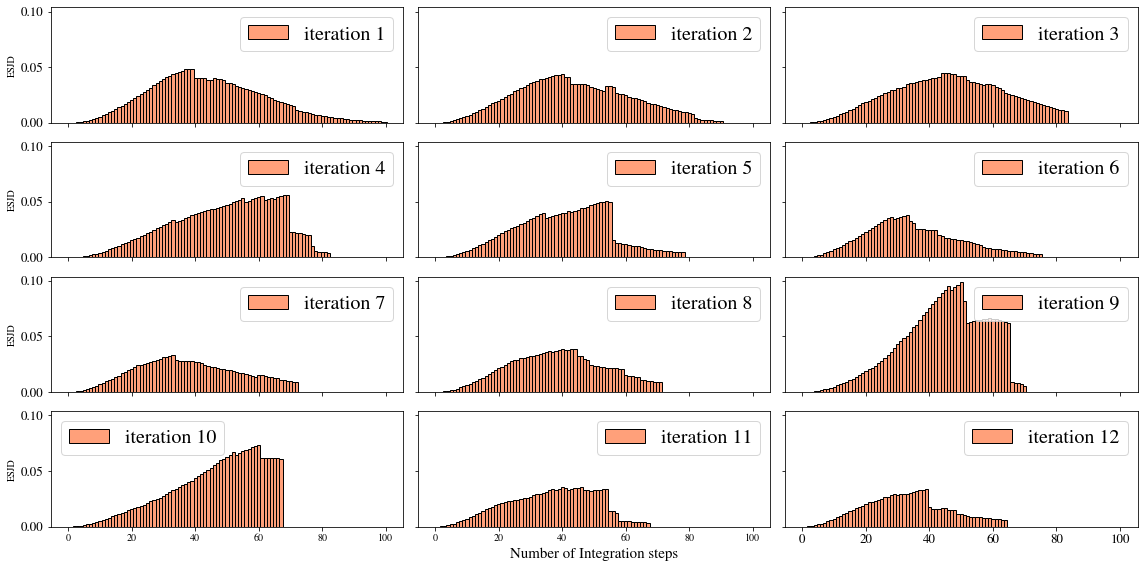

In [338]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].bar(np.arange(ONLY_AB99.Bs[INDEX1-1]+1), ONLY_AB99.ESJD_CHANG[INDEX1], width=1.0, edgecolor='k', color='lightsalmon', label="iteration 1")
ax[0, 0].legend(fontsize=20)
ax[0, 0].yaxis.set_tick_params(labelsize=13) 
ax[0, 0].set_ylabel("ESJD")

ax[0, 1].bar(np.arange(ONLY_AB99.Bs[INDEX2-1]+1), ONLY_AB99.ESJD_CHANG[INDEX2], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 2')
ax[0, 1].legend(fontsize=20)

ax[0, 2].bar(np.arange(ONLY_AB99.Bs[INDEX3-1]+1), ONLY_AB99.ESJD_CHANG[INDEX3], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 3')
ax[0, 2].legend(fontsize=20)
ax[0, 2].xaxis.set_tick_params(labelsize=13) 

ax[1, 0].bar(np.arange(ONLY_AB99.Bs[INDEX4-1]+1), ONLY_AB99.ESJD_CHANG[INDEX4], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 4')
ax[1, 0].legend(fontsize=20)
ax[1, 0].yaxis.set_tick_params(labelsize=13) 
ax[1, 0].set_ylabel("ESJD")

ax[1, 1].bar(np.arange(ONLY_AB99.Bs[INDEX5-1]+1), ONLY_AB99.ESJD_CHANG[INDEX5], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 5')
ax[1, 1].legend(fontsize=20)

ax[1, 2].bar(np.arange(ONLY_AB99.Bs[INDEX6-1]+1), ONLY_AB99.ESJD_CHANG[INDEX6], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 6')
ax[1, 2].legend(fontsize=20)
ax[1, 2].xaxis.set_tick_params(labelsize=13) 

ax[2, 0].bar(np.arange(ONLY_AB99.Bs[INDEX7-1]+1), ONLY_AB99.ESJD_CHANG[INDEX7], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 7')
ax[2, 0].legend(fontsize=20)
ax[2, 0].yaxis.set_tick_params(labelsize=13) 
ax[2, 0].set_ylabel("ESJD")

ax[2, 1].bar(np.arange(ONLY_AB99.Bs[INDEX8-1]+1), ONLY_AB99.ESJD_CHANG[INDEX8], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 8')
ax[2, 1].legend(fontsize=20)

ax[2, 2].bar(np.arange(ONLY_AB99.Bs[INDEX9-1]+1), ONLY_AB99.ESJD_CHANG[INDEX9], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 9')
ax[2, 2].legend(fontsize=20)
ax[2, 2].xaxis.set_tick_params(labelsize=13) 

ax[3, 0].bar(np.arange(ONLY_AB99.Bs[INDEX10-1]+1), ONLY_AB99.ESJD_CHANG[INDEX10], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 10')
ax[3, 0].legend(fontsize=20)
ax[3, 0].yaxis.set_tick_params(labelsize=13) 
ax[3, 0].set_ylabel("ESJD")

ax[3, 1].bar(np.arange(ONLY_AB99.Bs[INDEX11-1]+1), ONLY_AB99.ESJD_CHANG[INDEX11], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 11')
ax[3, 1].legend(fontsize=20)
ax[3, 1].set_xlabel("Number of Integration steps", fontsize=15)

ax[3, 2].bar(np.arange(ONLY_AB99.Bs[INDEX12-1]+1), ONLY_AB99.ESJD_CHANG[INDEX12], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 12')
ax[3, 2].legend(fontsize=20)
ax[3, 2].xaxis.set_tick_params(labelsize=13) 

plt.tight_layout()
plt.show()

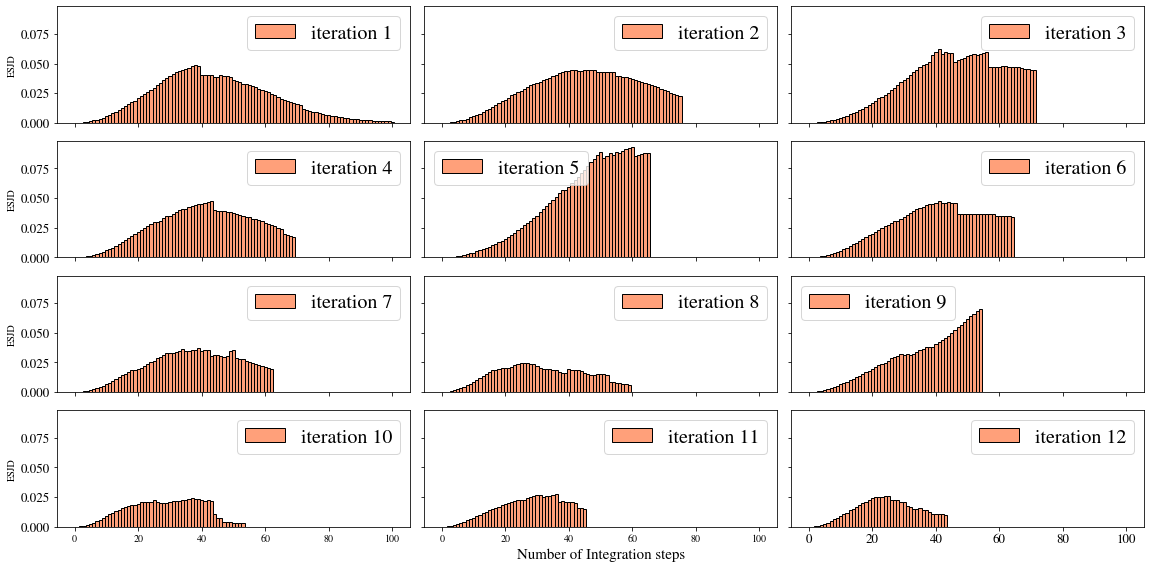

In [342]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].bar(np.arange(ONLY_AB_95.Bs[INDEX1-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX1], width=1.0, edgecolor='k', color='lightsalmon', label="iteration 1")
ax[0, 0].legend(fontsize=20)
ax[0, 0].yaxis.set_tick_params(labelsize=13) 
ax[0, 0].set_ylabel("ESJD")

ax[0, 1].bar(np.arange(ONLY_AB_95.Bs[INDEX2-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX2], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 2')
ax[0, 1].legend(fontsize=20)

ax[0, 2].bar(np.arange(ONLY_AB_95.Bs[INDEX3-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX3], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 3')
ax[0, 2].legend(fontsize=20)
ax[0, 2].xaxis.set_tick_params(labelsize=13) 

ax[1, 0].bar(np.arange(ONLY_AB_95.Bs[INDEX4-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX4], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 4')
ax[1, 0].legend(fontsize=20)
ax[1, 0].yaxis.set_tick_params(labelsize=13) 
ax[1, 0].set_ylabel("ESJD")

ax[1, 1].bar(np.arange(ONLY_AB_95.Bs[INDEX5-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX5], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 5')
ax[1, 1].legend(fontsize=20)

ax[1, 2].bar(np.arange(ONLY_AB_95.Bs[INDEX6-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX6], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 6')
ax[1, 2].legend(fontsize=20)
ax[1, 2].xaxis.set_tick_params(labelsize=13) 

ax[2, 0].bar(np.arange(ONLY_AB_95.Bs[INDEX7-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX7], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 7')
ax[2, 0].legend(fontsize=20)
ax[2, 0].yaxis.set_tick_params(labelsize=13) 
ax[2, 0].set_ylabel("ESJD")

ax[2, 1].bar(np.arange(ONLY_AB_95.Bs[INDEX8-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX8], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 8')
ax[2, 1].legend(fontsize=20)

ax[2, 2].bar(np.arange(ONLY_AB_95.Bs[INDEX9-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX9], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 9')
ax[2, 2].legend(fontsize=20)
ax[2, 2].xaxis.set_tick_params(labelsize=13) 

ax[3, 0].bar(np.arange(ONLY_AB_95.Bs[INDEX10-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX10], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 10')
ax[3, 0].legend(fontsize=20)
ax[3, 0].yaxis.set_tick_params(labelsize=13) 
ax[3, 0].set_ylabel("ESJD")

ax[3, 1].bar(np.arange(ONLY_AB_95.Bs[INDEX11-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX11], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 11')
ax[3, 1].legend(fontsize=20)
ax[3, 1].set_xlabel("Number of Integration steps", fontsize=15)

ax[3, 2].bar(np.arange(ONLY_AB_95.Bs[INDEX12-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX12], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 12')
ax[3, 2].legend(fontsize=20)
ax[3, 2].xaxis.set_tick_params(labelsize=13) 

plt.tight_layout()
plt.show()

Compare the two in some way

In [345]:
# KEEP IT FIXED
KEEP_B_FIXED = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[0], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
KEEP_B_FIXED_PARTICLES = KEEP_B_FIXED.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.8601940227620162
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9780000000000000
	Particle Diversity: 0.3140000000000000
	Moved Diversity: 0.3070920000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 31.0990122564994778
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9140000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.3893640000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.4433403691422875
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9100000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.3712800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.1492030270587410
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9180000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.4020840000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7360000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.3179520000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8484153256832867
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7240000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.3084240000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8090317939044454
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7180000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.3144840000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4940000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2143960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.0304320885572014
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5220000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.2223720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.0106523989603966
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5320000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.2394000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4260000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.1738080000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7126715612283421
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4980000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.2001960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6977112602899458
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4440000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1767120000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4340000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.1935640000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1603166484482634
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4640000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.2004480000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1373723253747532
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4060000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.1729560000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2940000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.1187760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8007725127870061
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2460000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1033200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  141
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7886422441713374
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2340000000000000
	Particle Diversity: 0.4900000000000000
	Moved Diversity: 0.1146600000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0760000000000000
	Particle Diversity: 0.3200000000000000
	Moved Diversity: 0.0243200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6231790300473483
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0700000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.0305200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  164
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6168158170906818
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0580000000000000
	Particle Diversity: 0.5860000000000000
	Moved Diversity: 0.0339880000000000
	Step-size kept fixed at: 0.0100000000000000

In [354]:
# KEEP IT FIXED
KEEP_B_FIXED20 = MSAdaptive(generate_settings(d=d, N=N, B=20,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[0], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
KEEP_B_FIXED20_PARTICLES = KEEP_B_FIXED20.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9560000000000000
	Particle Diversity: 0.3900000000000000
	Moved Diversity: 0.3728400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 39.1560168312226509
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9480000000000000
	Particle Diversity: 0.4300000000000000
	Moved Diversity: 0.4076399999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 30.0868814736943975
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8820000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.3598560000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5992729139147013
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8580000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.3397680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.2413115843731690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8820000000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.3633840000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5360000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2358400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3958203297600802
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5060000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.2216280000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3540495435607833
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4880000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.2078880000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2960000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.1278720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7386143420812228
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3800000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.1580800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7099915029490647
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5000000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.2020000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2460000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.0969240000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1230839089911875
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1920000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.0833280000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1058891524151031
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2060000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.0865200000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1920000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.0810240000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7709596447649345
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.0720720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7538432813133267
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.3680000000000000
	Moved Diversity: 0.0802240000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1200000000000000
	Particle Diversity: 0.1580000000000000
	Moved Diversity: 0.0189600000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4506030564731187
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0340000000000000
	Particle Diversity: 0.4880000000000000
	Moved Diversity: 0.0165920000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  141
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4396008745245447
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1320000000000000
	Particle Diversity: 0.1020000000000000
	Moved Diversity: 0.0134640000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Particle Diversity: 0.0020000000000000
	Moved Diversity: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000


In [356]:
# KEEP IT FIXED
KEEP_B_FIXED5 = MSAdaptive(generate_settings(d=d, N=N, B=5,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[0], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
KEEP_B_FIXED5_PARTICLES = KEEP_B_FIXED5.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Particle Diversity: 0.3820000000000000
	Moved Diversity: 0.3178240000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 38.1275523815565975
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8360000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.3611520000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 29.5091517218362824
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7980000000000000
	Particle Diversity: 0.4840000000000000
	Moved Diversity: 0.3862320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.1640288578019593
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.3710720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.8576051152688766
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Particle Diversity: 0.4680000000000000
	Moved Diversity: 0.3884400000000000
	Step-size kept fixed at: 0.0100000000000000


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7160000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.3222000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.6867263970415163
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7280000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.3319680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.5905259819188906
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7080000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.2888640000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6400000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.2700800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7257244137430030
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6320000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.2540640000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6525906104921182
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5679999999999999
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2499200000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4480000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1783040000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8686034834528229
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4540000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.1788760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8308514151008786
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4560000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.1851360000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3340000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.1503000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3951665151818187
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3660000000000000
	Particle Diversity: 0.3880000000000000
	Moved Diversity: 0.1420080000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3747069042693889
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3140000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1249720000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3300000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.1405800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8264517781263341
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3380000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.1399320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8075279342682302
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3120000000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.1285440000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1480000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.0615680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4011562821204566
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1880000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.0770800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3892086957693925
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1620000000000000
	Particle Diversity: 0.4640000000000000
	Moved Diversity: 0.0751680000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2540000000000000
	Particle Diversity: 0.1440000000000000
	Moved Diversity: 0.0365760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1606775234989319
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1260000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.0536760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1495351992250324
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1420000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.0533920000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0260000000000000
	Particle Diversity: 0.4980000000000000
	Moved Diversity: 0.0129480000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8838729335913350
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0520000000000000
	Particle Diversity: 0.3100000000000000
	Moved Diversity: 0.0161200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8791194501754998
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1080000000000000
	Particle Diversity: 0.1280000000000000
	Moved Diversity: 0.0138240000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1660000000000000
	Particle Diversity: 0.0960000000000000
	Moved Diversity: 0.0159360000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  231
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7086375239545583
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0320000000000000
	Particle Diversity: 0.4700000000000000
	Moved Diversity: 0.0150400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7037585844521961
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0280000000000000
	Particle Diversity: 0.5180000000000000
	Moved Diversity: 0.0145040000000000
	Step-size kept fixed at: 0.0100000000000000

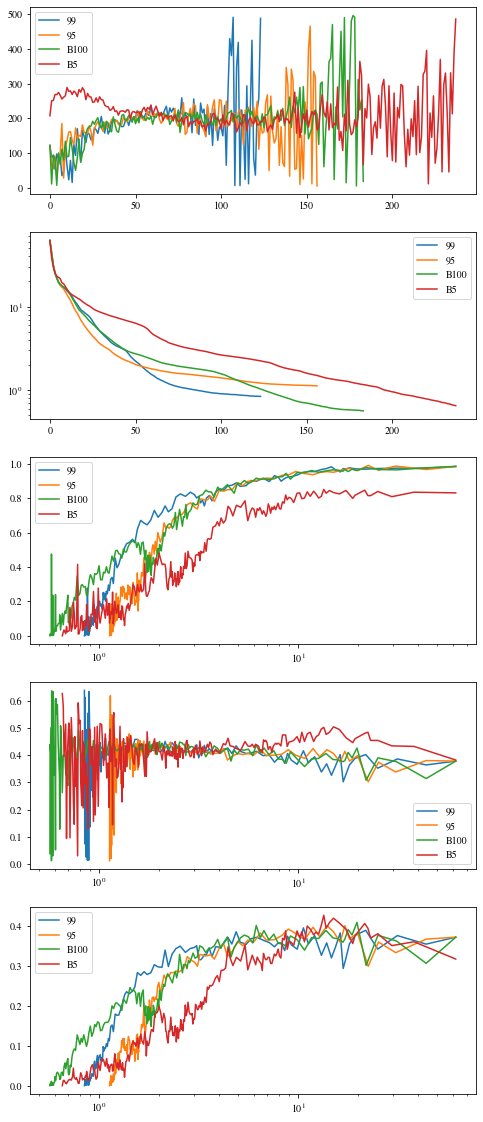

In [376]:
nrows=5
fig, ax = plt.subplots(nrows=nrows, figsize=(8, 4*nrows))
# ESS-SMC
ax[0].plot(ONLY_AB_99.ESS_SMC[1:], label='99')
ax[0].plot(ONLY_AB_95.ESS_SMC[1:], label='95')
ax[0].plot(KEEP_B_FIXED.ESS_SMC[1:], label='B100')
ax[0].plot(KEEP_B_FIXED5.ESS_SMC[1:], label='B5')
ax[0].legend()
# EPSILONS
ax[1].plot(ONLY_AB_99.εs[1:], label='99')
ax[1].plot(ONLY_AB_95.εs[1:], label='95')
ax[1].plot(KEEP_B_FIXED.εs[1:], label='B100')
ax[1].plot(KEEP_B_FIXED5.εs[1:], label='B5')
ax[1].set_yscale('log')
ax[1].legend()
# PROPORTION OF PARTICLES MOVED OVER EPSILON
ax[2].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.PROP_MOVED[1:], label='99')
ax[2].plot(ONLY_AB_95.εs[1:], ONLY_AB_95.PROP_MOVED[1:], label='95')
ax[2].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.PROP_MOVED[1:], label='B100')
ax[2].plot(KEEP_B_FIXED5.εs[1:], KEEP_B_FIXED5.PROP_MOVED[1:], label='B5')
ax[2].set_xscale('log')
ax[2].legend()
# PARTICLE DIVERSITY
ax[3].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.P_DIVERSITY[1:], label='99')
ax[3].plot(ONLY_AB_95.εs[1:], ONLY_AB_95.P_DIVERSITY[1:], label='95')
ax[3].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.P_DIVERSITY[1:], label='B100')
ax[3].plot(KEEP_B_FIXED5.εs[1:], KEEP_B_FIXED5.P_DIVERSITY[1:], label='B5')
ax[3].set_xscale('log')
ax[3].legend()
# DIVERSITY MOVED
ax[4].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.DIV_MOVED[1:], label='99')
ax[4].plot(ONLY_AB_95.εs[1:], ONLY_AB_95.DIV_MOVED[1:], label='95')
ax[4].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.DIV_MOVED[1:], label='B100')
ax[4].plot(KEEP_B_FIXED5.εs[1:], KEEP_B_FIXED5.DIV_MOVED[1:], label='B5')
ax[4].set_xscale('log')
ax[4].legend()
plt.legend()
plt.show()

Seems that small $B$ is fundamental.

# Relationship between $B$ and $N$

We fix the computational budget per iteration to $50000$ and compare two scenarios:

1. **Large $N$, small $B$**: $N=500$ and $B=100$
2. **Small $N$, large $B$**: $N=10\,000$ and $B=5$

In [375]:
# KEEP IT FIXED, LARGE B, SMALL N
B5N10k = MSAdaptive(generate_settings(d=d, N=10000, B=5,
        δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN10k.εs[0], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B5N10k_PARTICLES = B5N10k.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.0069753305084248
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8361000000000000
	Particle Diversity: 0.4485000000000000
	Moved Diversity: 0.3749908500000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.5073596183209617
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8405000000000000
	Particle Diversity: 0.4377000000000000
	Moved Diversity: 0.3678868500000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.9543887303735161
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8220000000000000
	Particle Diversity: 0.4614000000000000
	Moved Diversity: 0.3792708000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.6087987526476581
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8169000000000000
	Particle Diversity: 0.4677000000000000
	Moved Diversity: 0.3820641300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.1875258183879254
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8182000000000000
	Particle Diversity: 0.4755000000000000
	Moved Diversity: 0.3890541000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Epsilon: 3.3049217652082468
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6871000000000000
	Particle Diversity: 0.4282000000000000
	Moved Diversity: 0.2942162200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2219991944178781
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6814000000000000
	Particle Diversity: 0.4256000000000000
	Moved Diversity: 0.2900038400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1391520810072193
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6701000000000000
	Particle Diversity: 0.4326000000000000
	Moved Diversity: 0.2898852600000000
	Step-size kept f

	Epsilon: 1.7314372916220626
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5337000000000000
	Particle Diversity: 0.4219000000000000
	Moved Diversity: 0.2251680300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6878128780868191
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5159000000000000
	Particle Diversity: 0.4214000000000000
	Moved Diversity: 0.2174002600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6476027064928105
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4986000000000000
	Particle Diversity: 0.4293000000000000
	Moved Diversity: 0.2140489800000000
	Step-size kept f

	Epsilon: 1.1650058859644803
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4060000000000000
	Particle Diversity: 0.4173000000000000
	Moved Diversity: 0.1694238000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1261855196805031
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3839000000000000
	Particle Diversity: 0.4306000000000000
	Moved Diversity: 0.1653073400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0907503190963490
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3376000000000000
	Particle Diversity: 0.4449000000000000
	Moved Diversity: 0.1501982400000000
	Step-size kept f

	Epsilon: 0.6887058194643493
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1132000000000000
	Particle Diversity: 0.3886000000000000
	Moved Diversity: 0.0439895200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6766647872708185
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1145000000000000
	Particle Diversity: 0.3674000000000000
	Moved Diversity: 0.0420673000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6635482146227905
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0965000000000000
	Particle Diversity: 0.4162000000000000
	Moved Diversity: 0.0401633000000000
	Step-size kept

	Epsilon: 0.4598456592258399
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0240000000000000
	Particle Diversity: 0.3398000000000000
	Moved Diversity: 0.0081552000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4535705284910393
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0159000000000000
	Particle Diversity: 0.2248000000000000
	Moved Diversity: 0.0035743200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4484137499697994
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0128000000000000
	Particle Diversity: 0.3309000000000000
	Moved Diversity: 0.0042355200000000
	Step-size kept

	Epsilon: 0.3646092279259172
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0025000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.0011150000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3586607704561044
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0077000000000000
	Particle Diversity: 0.2072000000000000
	Moved Diversity: 0.0015954400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3524024011839417
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0021000000000000
	Particle Diversity: 0.3027000000000000
	Moved Diversity: 0.0006356700000000
	Step-size kept

	Epsilon: 0.2444058209011026
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0004000000000000
	Particle Diversity: 0.5480000000000000
	Moved Diversity: 0.0002192000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2433817933397504
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Particle Diversity: 0.0010000000000000
	Moved Diversity: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000


Now compare the two

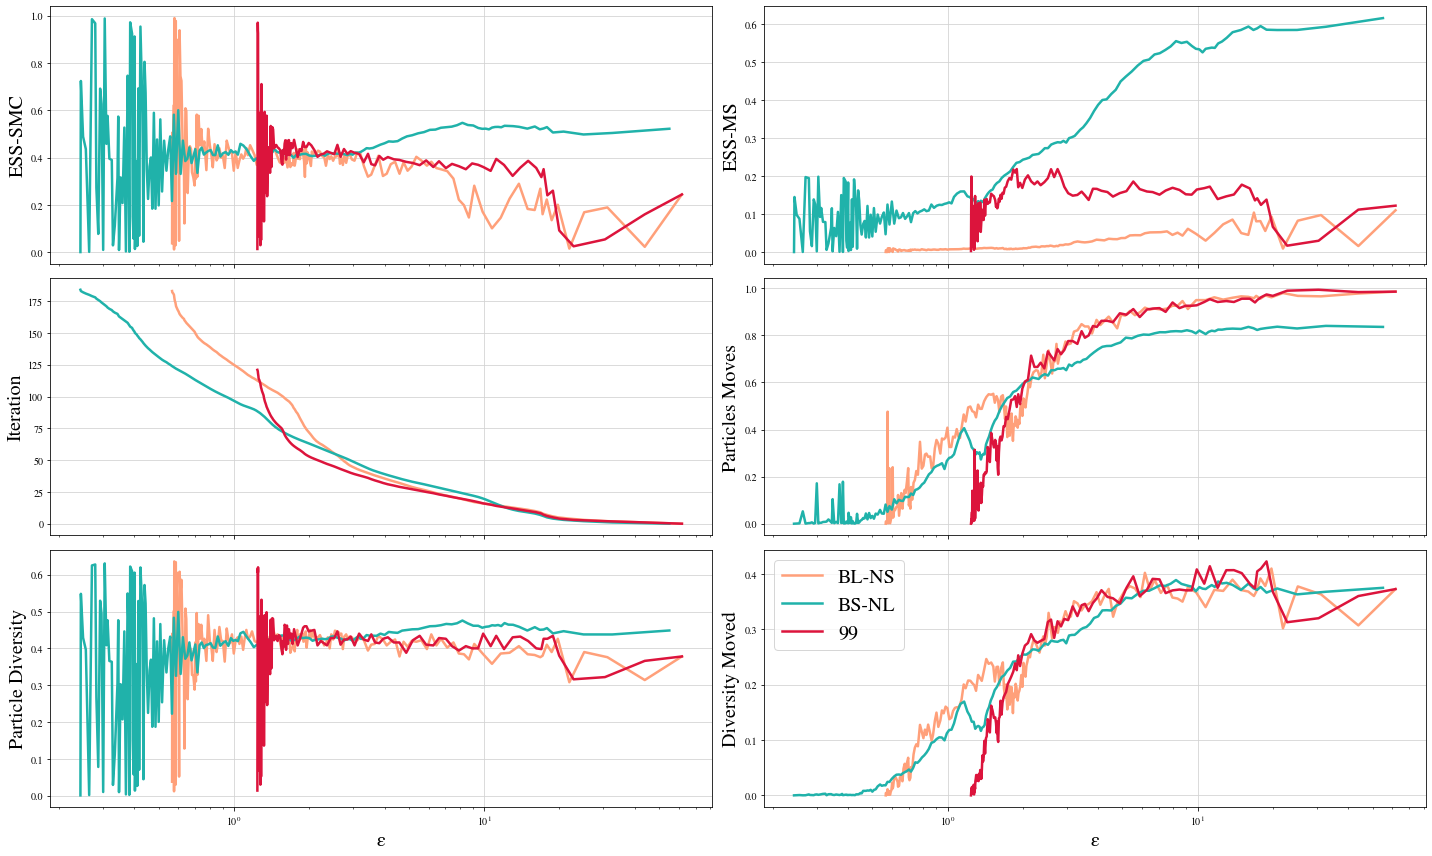

In [477]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 12), sharex=True)
FS=20
LFS=20
LW = 2.5
C1 = "lightsalmon"
C2 = "lightseagreen"
C3 = "crimson"
# ESS-SMC
ax[0, 0].plot(KEEP_B_FIXED.εs[1:], np.array(KEEP_B_FIXED.ESS_SMC[1:])/KEEP_B_FIXED.N, label='BL-NS', lw=LW, color=C1) #N=500, B=100
ax[0, 0].plot(B5N10k.εs[1:], np.array(B5N10k.ESS_SMC[1:])/B5N10k.N, label='BS-NL', lw=LW, color=C2)       #N=10000, B=5
ax[0, 0].plot(ONLY_AB_99.εs[1:], np.array(ONLY_AB_99.ESS_SMC[1:])/ONLY_AB_99.N, label='99', lw=LW, color=C3)
ax[0, 0].set_xscale('log')
# ax[0, 0].legend(fontsize=LFS) 
ax[0, 0].set_ylabel("ESS-SMC", fontsize=FS)
# ESS-MS
ax[0, 1].plot(KEEP_B_FIXED.εs[1:], np.array(KEEP_B_FIXED.ESS[1:])/50000, label='BL-NS', lw=LW, color=C1) #N=500, B=100
ax[0, 1].plot(B5N10k.εs[1:], np.array(B5N10k.ESS[1:])/50000, label='BS-NL', lw=LW, color=C2)       #N=10000, B=5
ax[0, 1].plot(ONLY_AB_99.εs[1:], np.array(ONLY_AB_99.ESS[1:]) / (np.array(ONLY_AB_99.Bs[1:])*ONLY_AB_99.N), label='99', lw=LW, color=C3)
ax[0, 1].set_xscale('log')
# ax[0, 1].legend(fontsize=LFS) 
ax[0, 1].set_ylabel("ESS-MS", fontsize=FS)
# EPSILONS
ax[1, 0].plot(KEEP_B_FIXED.εs[1:], np.arange(len(KEEP_B_FIXED.εs[1:])), label='BL-NS', lw=LW, color=C1)
ax[1, 0].plot(B5N10k.εs[1:], np.arange(len(B5N10k.εs[1:])), label='BS-NL', lw=LW, color=C2)
ax[1, 0].plot(ONLY_AB_99.εs[1:], np.arange(len(ONLY_AB_99.εs[1:])), label='99', lw=LW, color=C3)
ax[1, 0].set_xscale('log')
# ax[1, 0].legend(fontsize=LFS)
ax[1, 0].set_ylabel("Iteration", fontsize=FS)
# PROPORTION OF PARTICLES MOVED OVER EPSILON
ax[1, 1].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.PROP_MOVED[1:], label='BL-NS', lw=LW, color=C1)
ax[1, 1].plot(B5N10k.εs[1:], B5N10k.PROP_MOVED[1:], label='BS-NL', lw=LW, color=C2)
ax[1, 1].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.PROP_MOVED[1:], label='99', lw=LW, color=C3)
ax[1, 1].set_xscale('log')
# ax[1, 1].legend(fontsize=LFS)
ax[1, 1].set_ylabel("Particles Moves", fontsize=FS)
# PARTICLE DIVERSITY
ax[2, 0].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.P_DIVERSITY[1:], label='BL-NS', lw=LW, color=C1)
ax[2, 0].plot(B5N10k.εs[1:], B5N10k.P_DIVERSITY[1:], label='BS-NL', lw=LW, color=C2)
ax[2, 0].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.P_DIVERSITY[1:], label='99', lw=LW, color=C3)
ax[2, 0].set_xscale('log')
# ax[2, 0].legend(fontsize=LFS)
ax[2, 0].set_ylabel("Particle Diversity", fontsize=FS)
ax[2, 0].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=FS)
# DIVERSITY MOVED
ax[2, 1].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.DIV_MOVED[1:], label='BL-NS', lw=LW, color=C1)
ax[2, 1].plot(B5N10k.εs[1:], B5N10k.DIV_MOVED[1:], label='BS-NL', lw=LW, color=C2)
ax[2, 1].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.DIV_MOVED[1:], label='99', lw=LW, color=C3)
ax[2, 1].set_xscale('log')
# ax[2, 1].legend(fontsize=LFS)
ax[2, 1].set_ylabel("Diversity Moved", fontsize=FS)
ax[2, 1].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=FS)
for i in range(3):
    for j in range(2):
        ax[i, j].grid(True, color='lightgray')
plt.legend(fontsize=LFS)
plt.tight_layout()
# plt.savefig("figures/gk20_relationship_bn.png")
plt.show()

The key difference is that BL-NS and BS-NL keep the computational budget fixed, whereas 99 doesn't and at the end it basically has 500 particles moving by 5 steps at a time. Instead, I want to do something similar for it.

In [509]:
# adapt δ based on EJSD, but keep B fixed (use prop_esjd=0.99)
AB_AN_99 = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.99, adaptiveN=True, NBbudget=50000))
AB_AN_99_PARTICLES = AB_AN_99.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Number of steps adapted to: 90
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.8662129680175212
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9837837837837838
	Particle Diversity: 0.3315315315315315
	Moved Diversity: 0.3261553445337229
	Number of steps adapted to: 88
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 34.8309840500656946
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop 

In [440]:
# with open("B5N10k_ess_ms.pkl", "wb") as file:
#     pickle.dump(B5N10k.ESS, file)